In [3]:
# Importing our dependencies
import pandas as pd
from pyspark import SparkFiles
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [4]:
# Creating a spark session
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

23/06/13 10:12:26 WARN Utils: Your hostname, Sumaiyas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.0.0.72 instead (on interface en0)
23/06/13 10:12:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/13 10:12:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/13 10:12:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/06/13 10:12:28 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [5]:
# Importing and reading the clean data using spark
clean_df = spark.read.csv("../abedasalsabil spotify main cleaning%20/cleaning/Resources/clean_May_tracks.csv", header=True, inferSchema=True)

# Showing DataFrame
clean_df.show()

+--------------------+--------------------+----------+----------+------------+------+----+--------+-----------+------------+----------------+--------+-------+-------+--------------------+
|          track.name|          album_name|album_type|popularity|danceability|energy| key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|              artist|
+--------------------+--------------------+----------+----------+------------+------+----+--------+-----------+------------+----------------+--------+-------+-------+--------------------+
|#Sarkanbaltsarkanais|#Sarkanbaltsarkanais|    single|      38.0|       0.738| 0.785|11.0|  -5.003|      0.104|      0.0608|             0.0|   0.403|  0.626|110.118|   Bermudu Divstūris|
|  'Til We Meet Again|MY WORLD - The 3r...|    single|      63.0|       0.474| 0.857| 5.0|  -2.577|     0.0571|       0.134|             0.0|   0.113|  0.552| 155.71|               aespa|
|               00:00|               00:00|    single|      

In [6]:
# Creating our temporary view
clean_df.createOrReplaceTempView('spotify')

In [7]:
# Most number of songs released per artist - top 10
spark.sql("""
  SELECT
    artist,
    count(*) AS number_of_songs
  FROM spotify
  GROUP BY artist
  ORDER BY 2 DESC
  LIMIT 10
  """).show()

+------------+---------------+
|      artist|number_of_songs|
+------------+---------------+
|    Azahriah|             21|
|    Måneskin|             18|
|       RICTA|             17|
|       Separ|             16|
| Hafdís Huld|             15|
|   BLACKPINK|             15|
|Taylor Swift|             14|
|  Emis Killa|             14|
|      FLY LO|             14|
|   Baby Gang|             14|
+------------+---------------+



In [8]:
# Converting spark dataframe to pandas dataframe
track_df = clean_df.toPandas()

In [9]:
track_df.dtypes

track.name           object
album_name           object
album_type           object
popularity           object
danceability         object
energy              float64
key                 float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
artist               object
dtype: object

In [10]:
track_df['popularity'].value_counts()

63.0            88
56.0            85
64.0            81
74.0            78
73.0            78
                ..
98.0             1
10.0             1
13.0             1
 Vol. 10"")"     1
100.0            1
Name: popularity, Length: 101, dtype: int64

In [11]:
track_df = track_df[~track_df['popularity'].str.contains(' ')]

In [12]:
track_df['popularity'] = track_df['popularity'].astype(float)
track_df['danceability'] = track_df['danceability'].astype(float)

# Feature Engineering -
Since our goal is to be able to identify which tracks will be popular, we need to feature engineer a new column by binarizing the popularity column. To be able to do this, we need to decide on a cut-off point of popularity score which if a song stays above this cut-off point it will be considered "popular" and if it stays below it will be considered "not popular". We can start off by taking a look at the distribution of the popularity score distribution.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
track_df.corr()

,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
popularity,1.000000,-0.054423,0.016424,-0.007676,0.159569,-0.158958,-0.010214,-0.027113,0.023117,-0.040645,0.033167
danceability,-0.054423,1.000000,0.125778,0.043556,0.070837,0.169038,-0.187504,-0.017882,-0.119558,0.369787,-0.146266
energy,0.016424,0.125778,1.000000,0.034755,0.700485,0.008383,-0.533418,-0.060217,0.167635,0.336553,0.081133
key,-0.007676,0.043556,0.034755,1.000000,0.030573,0.029615,-0.033034,-0.001755,0.004458,0.075491,0.020454
loudness,0.159569,0.070837,0.700485,0.030573,1.000000,-0.067835,-0.363211,-0.220618,0.111077,0.252590,0.052744
speechiness,-0.158958,0.169038,0.008383,0.029615,-0.067835,1.000000,-0.005330,-0.045710,-0.018776,0.058101,0.054575
acousticness,-0.010214,-0.187504,-0.533418,-0.033034,-0.363211,-0.005330,1.000000,-0.010252,-0.039812,-0.142881,-0.045792
instrumentalness,-0.027113,-0.017882,-0.060217,-0.001755,-0.220618,-0.045710,-0.010252,1.000000,-0.030214,-0.083187,0.014306
liveness,0.023117,-0.119558,0.167635,0.004458,0.111077,-0.018776,-0.039812,-0.030214,1.000000,0.065367,0.028622
valence,-0.040645,0.369787,0.336553,0.075491,0.252590,0.058101,-0.142881,-0.083187,0.065367,1.000000,0.048473


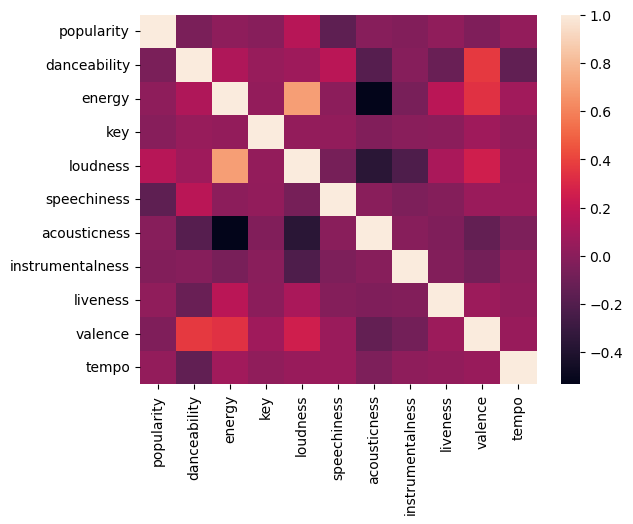

In [15]:
# Creating a heatmap to visualize correlations 
ax = sns.heatmap(track_df.corr(), annot=False)

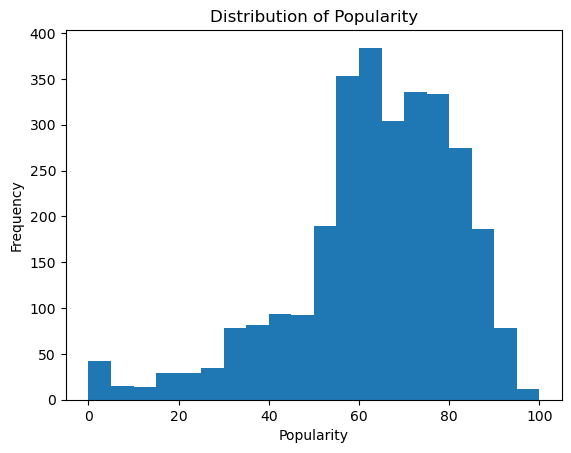

Mean Popularity: 63.281999324552515
Median Popularity: 65.0
75th Percentile Popularity: 77.0


In [16]:
# Distribution of popularity

import matplotlib.pyplot as plt

# Plot a histogram of the 'popularity' feature
plt.hist(track_df['popularity'], bins=20)
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title('Distribution of Popularity')
plt.show()

# Calculate summary statistics
popularity_mean = track_df['popularity'].mean()
popularity_median = track_df['popularity'].median()
popularity_percentile = track_df['popularity'].quantile(0.75)

print("Mean Popularity:", popularity_mean)
print("Median Popularity:", popularity_median)
print("75th Percentile Popularity:", popularity_percentile)

In [17]:
#creating is_popular column with our cutoff point
track_df['is_popular']=(track_df['popularity']>=65).astype('int')
track_df.head()

,track.name,album_name,album_type,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist,is_popular
0,#Sarkanbaltsarkanais,#Sarkanbaltsarkanais,single,38.0,0.738,0.785,11.0,-5.003,0.1040,0.0608,0.00000,0.403,0.6260,110.118,Bermudu Divstūris,0
1,'Til We Meet Again,MY WORLD - The 3rd Mini Album,single,63.0,0.474,0.857,5.0,-2.577,0.0571,0.1340,0.00000,0.113,0.5520,155.710,aespa,0
2,00:00,00:00,single,60.0,0.563,0.572,4.0,-8.769,0.1250,0.6400,0.00227,0.100,0.3920,95.013,Lartiste,0
3,0321,0321,single,67.0,0.658,0.417,2.0,-6.485,0.0366,0.6250,0.00000,0.132,0.0748,171.974,space x,1
4,085 - Ao Vivo,Pode Crê (Ao Vivo),album,83.0,0.850,0.655,2.0,-2.891,0.0298,0.2110,0.00000,0.952,0.7970,106.031,MC Rogerinho,1


In [18]:
#dropping popularity score column since we will not be using it
track_df.drop(['popularity'], axis=1, inplace=True)
track_df.head()

,track.name,album_name,album_type,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist,is_popular
0,#Sarkanbaltsarkanais,#Sarkanbaltsarkanais,single,0.738,0.785,11.0,-5.003,0.1040,0.0608,0.00000,0.403,0.6260,110.118,Bermudu Divstūris,0
1,'Til We Meet Again,MY WORLD - The 3rd Mini Album,single,0.474,0.857,5.0,-2.577,0.0571,0.1340,0.00000,0.113,0.5520,155.710,aespa,0
2,00:00,00:00,single,0.563,0.572,4.0,-8.769,0.1250,0.6400,0.00227,0.100,0.3920,95.013,Lartiste,0
3,0321,0321,single,0.658,0.417,2.0,-6.485,0.0366,0.6250,0.00000,0.132,0.0748,171.974,space x,1
4,085 - Ao Vivo,Pode Crê (Ao Vivo),album,0.850,0.655,2.0,-2.891,0.0298,0.2110,0.00000,0.952,0.7970,106.031,MC Rogerinho,1


In [19]:
track_df["is_popular"].value_counts()

1    1525
0    1436
Name: is_popular, dtype: int64

# Logistic Regression Model with the Original Data

In [62]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
#import tensorflow as tf

In [63]:
#Split the data into features (X) and target (y)
y = track_df[['is_popular']]
X = track_df[['speechiness','acousticness','liveness','valence','energy','loudness']]

In [64]:
# Import the train_test_learn module
from sklearn.model_selection import train_test_split

# Split the data using train_test_split
# Assign a random_state of 1 to the function
x_train,x_test,y_train,y_test= train_test_split(X,y)

In [65]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_regression_model = LogisticRegression(random_state=1)

# Fit the model using training data
lr_model = logistic_regression_model.fit(x_train, y_train)

/Users/sumaiyanathani/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
# Make a prediction using the testing data
testing_predictions = lr_model.predict(x_test)

In [67]:
# Print the balanced_accuracy score of the model
print(f"Training Data Score: {lr_model.score(x_train, y_train)}")
print(f"Testing Data Score: {lr_model.score(x_test, y_test)}")

from sklearn.metrics import accuracy_score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, testing_predictions)}")

Training Data Score: 0.6135135135135135
Testing Data Score: 0.6153846153846154
Balanced Accuracy Score: 0.6118011289875578


In [68]:
# Generate a confusion matrix for the model
from sklearn.metrics import confusion_matrix

testing_matrix = confusion_matrix(y_test, testing_predictions)
print(testing_matrix)

[[181 177]
 [108 275]]


In [69]:
# Print the classification report for the model
testing_report = classification_report(y_test, testing_predictions)

print(testing_report)

              precision    recall  f1-score   support

           0       0.63      0.51      0.56       358
           1       0.61      0.72      0.66       383

    accuracy                           0.62       741
   macro avg       0.62      0.61      0.61       741
weighted avg       0.62      0.62      0.61       741



For the "0" label (NOT POPULAR), the precision is 0.63, indicating that the model  predicts not popular track with a precision of 63%. For the "1" label (popular), the precision is 0.61, meaning that when the model predicts popular track, it is correct around 61% of the time.

For the "0" label (Not popular), the recall is 0.51, . For the "1" label (POPULAR), the recall is 0.72, meaning that the model captures approximately 72% of the actual popular track.

Overall, the logistic regression model demonstrates  predictive performance for both the "0" and "1" labels.

# Predict a Logistic Regression Model with Resampled Training Data

In [70]:
# Import the RandomOverSampler module form imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
ROS = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
x_resampled, y_resampled= ROS.fit_resample(x_train, y_train)

In [71]:
# Count the distinct values of the resampled labels data
y_resampled.value_counts()

is_popular
0             1142
1             1142
dtype: int64

In [72]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
from sklearn.linear_model import LogisticRegression
ros_model = LogisticRegression(solver='lbfgs', random_state=1)


# Fit the model using the resampled training data
ros_model.fit(x_resampled, y_resampled)


# Make a prediction using the testing data
y_prediction = ros_model.predict(x_test)

/Users/sumaiyanathani/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [73]:
# Print the balanced_accuracy score of the model 
print(f"Training Data Score: {ros_model.score(x_train, y_train)}")
print(f"Testing Data Score: {ros_model.score(x_test, y_test)}")

from sklearn.metrics import accuracy_score
# Display the accuracy score for the test dataset.
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_prediction)}")

Training Data Score: 0.6099099099099099
Testing Data Score: 0.6126855600539811
Balanced Accuracy Score: 0.6104664731537262


In [74]:
# Generate a confusion matrix for the model
from sklearn.metrics import confusion_matrix
ros_testing_matrix = confusion_matrix(y_test, y_prediction)
print(ros_testing_matrix)

[[195 163]
 [124 259]]


In [75]:
# Print the classification report for the model
ros_testing_report = classification_report(y_test, y_prediction)

print(ros_testing_report)

              precision    recall  f1-score   support

           0       0.61      0.54      0.58       358
           1       0.61      0.68      0.64       383

    accuracy                           0.61       741
   macro avg       0.61      0.61      0.61       741
weighted avg       0.61      0.61      0.61       741



# NeuralNetwork

In [23]:
#Split the data into features (X) and target (y)
y = track_df[['is_popular']]
X = track_df[['speechiness','acousticness','liveness','valence','energy','loudness']]

In [24]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [25]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [26]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 9
hidden_nodes_layer2 = 18

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 63        
                                                                 
 dense_1 (Dense)             (None, 18)                180       
                                                                 
 dense_2 (Dense)             (None, 1)                 19        
                                                                 
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [28]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
70/70 [==============================] - 1s 1ms/step - loss: 0.7161 - accuracy: 0.5079
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6863 - accuracy: 0.5398
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6807 - accuracy: 0.5552
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6767 - accuracy: 0.5718
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6734 - accuracy: 0.5795
Epoch 6/100
70/70 [==============================] - 0s 1ms/step - loss: 0.6709 - accuracy: 0.6015
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6692 - accuracy: 0.5970
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6673 - accuracy: 0.6051
Epoch 9/100
70/70 [==============================] - 0s 1ms/step - loss: 0.6657 - accuracy: 0.6011
Epoch 10/100
70/70 [==============================] - 0s 1ms/step - loss: 0.6644 - accuracy: 0.6024
Epoch 11/

In [29]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

24/24 - 0s - loss: 0.6481 - accuracy: 0.6046 - 244ms/epoch - 10ms/step
Loss: 0.6481249332427979, Accuracy: 0.6045883893966675


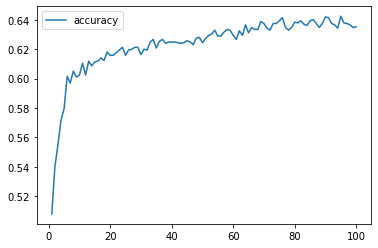

In [30]:
# plotting the accuracy
history_df = pd.DataFrame(fit_model.history, index = range(1, len(fit_model.history['loss'])+1))
history_df.plot(y = 'accuracy')

cutoff = 65 ,layer1 = 9 : activation function = relu layer2 = 18 : activation function = relu

Loss: 0.654283881187439, Accuracy: 0.6126855611801147

A loss value of 65 indicates that the model can be further optimized. The accuracy percent shows that 61% of the model's predicted values align with the true values in the original dataset.

# Adding hidden layer

In [31]:


# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 9
hidden_nodes_layer2 = 18
hidden_nodes_layer3 = 27

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))





# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 9)                 63        
                                                                 
 dense_4 (Dense)             (None, 18)                180       
                                                                 
 dense_5 (Dense)             (None, 27)                513       
                                                                 
 dense_6 (Dense)             (None, 1)                 28        
                                                                 
Total params: 784
Trainable params: 784
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [33]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
70/70 [==============================] - 1s 2ms/step - loss: 0.6909 - accuracy: 0.5254
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6814 - accuracy: 0.5763
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6742 - accuracy: 0.5966
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6678 - accuracy: 0.6060
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6638 - accuracy: 0.6029
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6600 - accuracy: 0.6119
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6569 - accuracy: 0.6155
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6556 - accuracy: 0.6110
Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6546 - accuracy: 0.6213
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6520 - accuracy: 0.6150
Epoch 11/

In [34]:
#Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

24/24 - 0s - loss: 0.6508 - accuracy: 0.6154 - 207ms/epoch - 9ms/step
Loss: 0.6507761478424072, Accuracy: 0.6153846383094788


# Changing activation

In [35]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 9
hidden_nodes_layer2 = 18
hidden_nodes_layer3 = 81


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))




# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 9)                 63        
                                                                 
 dense_8 (Dense)             (None, 18)                180       
                                                                 
 dense_9 (Dense)             (None, 81)                1539      
                                                                 
 dense_10 (Dense)            (None, 1)                 82        
                                                                 
Total params: 1,864
Trainable params: 1,864
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [37]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
70/70 [==============================] - 1s 2ms/step - loss: 0.6750 - accuracy: 0.5745
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6688 - accuracy: 0.5925
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6677 - accuracy: 0.5921
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6660 - accuracy: 0.5952
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6647 - accuracy: 0.6024
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6640 - accuracy: 0.6029
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6632 - accuracy: 0.5993
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6634 - accuracy: 0.6047
Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6613 - accuracy: 0.6092
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6613 - accuracy: 0.6024
Epoch 11/

In [38]:
#Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

24/24 - 0s - loss: 0.6425 - accuracy: 0.6221 - 218ms/epoch - 9ms/step
Loss: 0.6425341367721558, Accuracy: 0.6221322417259216


In [39]:
# Export our model to HDF5 file
nn.save('Model/Model.h5')

# random forest 

In [76]:
from sklearn.ensemble import RandomForestClassifier
# Update X with the 'loudness' and 'energy' columns
X = track_df[['speechiness','acousticness','liveness','valence','energy','loudness']]

# Update y with the target variable column
y = track_df['is_popular'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
# Print the accuracies of the three models
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.581787521079258


In [77]:
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.19101229032077624, 'loudness'),
 (0.17813083290798945, 'speechiness'),
 (0.16431360086293684, 'energy'),
 (0.16101037253360215, 'acousticness'),
 (0.15493985458775805, 'valence'),
 (0.15059304878693716, 'liveness')]

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

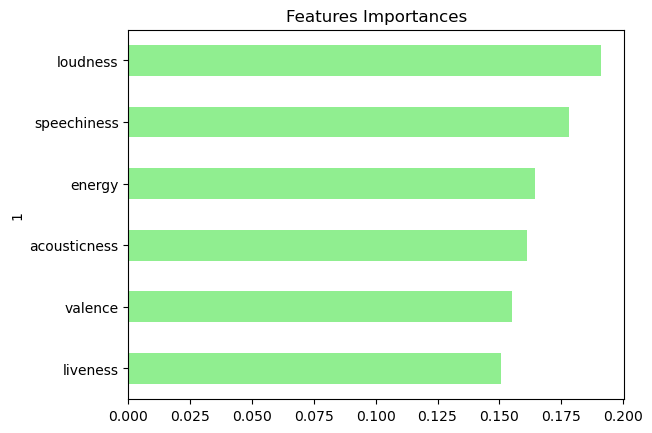

In [78]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)